In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [97]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [98]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=2
n2=20
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), IndependenceCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [300]:
import warnings
import sys
import traceback
from tqdm import tqdm
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def get_model(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
            return 0
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        return model
    else:
        print('Weights file {} not found.'.format(get_weights_filename))
        return 0
        
def measure_MI(model,points,samp_mc_size=10000):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
    f_mean = model(points).mean.unsqueeze(0)
    # now add mean f to a set of f samples
    fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]

    copula = model.likelihood(fs)
    MIs = copula.entropy()
    MI_mean = MIs[-1]
    MIs = MIs[:-1]

    return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,20)
        
n1=1
n2=4

print(data[n1+5,n2+5][1])

%time model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (ym, y, dy) = measure_MI(model, points)

FrankGaussian
['/home/nina/models/ST263_Day4/model_1-4.pth']
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 12.1 ms
CPU times: user 14min 9s, sys: 1.25 s, total: 14min 10s
Wall time: 26.7 s


(-0.5, 0)

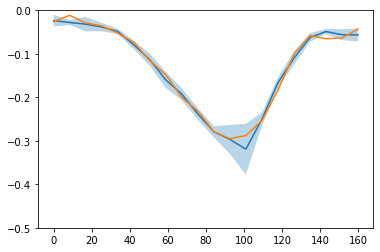

In [301]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [622]:
def stimMI(copula, pS=None, alpha=0.05, sem_tol=1e-3, mc_size=10000):
    '''
    Estimates the mutual information between a pair of uniformely
    distributed copula-transformed variables and the conditioning variable
    with the Robbins-Monro algorithm over responses.
    Parameters
    ----------
    pS : Tensor
        Prior over stimuli P(S). TODO: this, now assume uniform!
    alpha : float, optional
        Significance level of the entropy estimate.  (Default: 0.05)
    sem_tol : float, optional
        Maximum standard error as a stopping criterion.  (Default: 1e-3)
    mc_size : integer, optional
        Number of samples that are drawn in each iteration of the Monte
        Carlo estimation.  (Default: 10000)
    Returns
    -------
    ent : float
        Estimate of the mixed vine entropy in bits.
    sem : float
        Standard error of the mixed vine entropy estimate in bits.
    '''
    # Gaussian confidence interval for sem_tol and level alpha
    conf = torch.erfinv(torch.tensor([1. - alpha]))
    batch_shape = copula.batch_shape[1:] #first dm is number of copulas, discard it
    #assume that batch_shape = [samples_f shape x conditional variable]
    
    if pS is None:
        pS = torch.ones(batch_shape[-1])*1/(batch_shape[-1])
    assert pS.dim() == 1
    assert pS.shape[0] == batch_shape[-1]
    assert torch.allclose(pS.sum(),torch.ones(1))
    pS_ = pS.expand([mc_size,*batch_shape])

    sem = torch.ones(batch_shape)*float('inf')
    MI = torch.zeros(batch_shape) #theta here must have dims: fs x batch dims
    var_sum = torch.zeros(batch_shape)
    log2 = torch.tensor([2.]).log()
#     x, y = [torch.tensor(i) for i in np.mgrid[0:mc_size,0:batch_shape[1]]]
#     perm = torch.randperm(mc_size * batch_shape[1]) #premutations for samples x positions
#     x_ = x.view(-1)[perm]
#     y_ = y.view(-1)[perm]
    k = 0
    with torch.no_grad():
        while torch.any(sem >= sem_tol):
            # Generate samples
            samples = copula.rsample(sample_shape = torch.Size([mc_size]))
            # size [samples, fs, positions, 2]
            #samples2 = samples[x_,:,y_,:].view(samples.shape)
#             samples = torch.einsum("ijk...->jik...",samples)
#             samples = samples[:,x_,y_,:].reshape(samples.shape)
#             samples = torch.einsum("ijk...->jik...",samples)
#             samples = torch.einsum("ijk...->ikj...",samples) # samples x Xs x fs x 2
#             samples = samples.reshape(-1,*samples.shape[2:]) # (samples * Xs) x fs x 2
#             samples = samples.unsqueeze(dim=-2) # (samples * Xs) x fs x 1 x 2
#             samples = samples.expand([samples.shape[0],*batch_shape,2]) # (samples * Xs) x fs x Xs x 2
            # now these are samples from p(s,r)
            logpRgS = copula.log_prob(samples) # [sample dim, batch dims]
            assert torch.all(logpRgS==logpRgS)
            assert torch.all(logpRgS.abs()!=float("inf")) #otherwise make masked tensor below  
            logpR = ((logpRgS.exp()*pS_).sum(dim=-1)).log() # sum over stimuli p(r) = sum p(r|s) p(s)
            assert torch.all(logpR==logpR)
            assert torch.all(logpR.abs()!=float("inf"))
            #logpR = logpR.unsqueeze(-1).expand(logpRgS.shape)
            #print(logpR.shape,logpRgS.shape)
            log2p = (logpRgS - logpR.unsqueeze(-1)) / log2 #maybe should check for inf 2 lines earlier
            k += 1
            if k>100:
                print('MC integral failed to converge')
                break
            # Monte-Carlo estimate of entropy
            MI += ((pS_*log2p).mean(dim=0) - MI) / k # mean over samples dimension
            # Estimate standard error
            var_sum += ((((pS_*log2p) - MI)) ** 2).sum(dim=0) 
            sem = conf * (var_sum / (k * mc_size*batch_shape[-1] * (k * mc_size*batch_shape[-1] - 1))).pow(.5)
            #print(MI.sum(dim=-1).mean())
            print(sem.max()/sem_tol)
    return MI#, sem

def direct_stimMI(copula, pS=None, size=10000):
    # Gaussian confidence interval for sem_tol and level alpha
    batch_shape = copula.batch_shape[1:] #first dm is number of copulas, discard it
    #assume that batch_shape = [samples_f shape x conditional variable]
    
    if pS==None:
        pS = torch.ones(batch_shape[-1])*1/(batch_shape[-1])
    assert pS.dim() == 1
    assert pS.shape[0] == batch_shape[-1]
    
    MI = torch.zeros(batch_shape) #theta here must have dims: fs x batch dims
    log2 = torch.tensor([2.]).log()
    samples = (torch.stack([torch.tensor(i,dtype=torch.float) for i in np.mgrid[0:size,0:size]])/size)
    samples = torch.einsum('i...->...i',samples)
    samples = samples.view(-1,2)
    samples = samples.unsqueeze(dim=-2).unsqueeze(dim=-2)
    samples = samples.expand([size*size,*batch_shape,2])
    logpRgS = copula.log_prob(samples) # [sample dim, batch dims]
    assert torch.all(logpRgS==logpRgS)
    assert torch.all(logpRgS.abs()!=float("inf")) #otherwise make masked tensor below  
    print(logpRgS.shape)
    logpR = (logpRgS.exp().mean(dim=-1)).log() # ADD PRIOR!!!
    #print(logpR.shape,logpRgS.shape)
    log2p = (logpRgS - logpR.unsqueeze(-1)) / log2 #maybe should check for inf 2 lines earlier
    return log2p.sum(dim=0)/batch_shape[-1]


In [623]:
def measure_MI(model,points,pS=None,r_mc_size=10000,f_mc_size=10,sem_tol=1e-4):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([f_mc_size])) #[samples_f, copulas, positions]
    #fs = fs.expand([f_mc_size,*fs.shape[1:]])
    copula = model.likelihood(fs)
    #MI = direct_stimMI(copula, size=500)
    MI = stimMI(copula, pS=pS, sem_tol=sem_tol, mc_size=r_mc_size)
    if pS is not None:
        plt.imshow(MI/pS.expand(MI.shape))
    MIs = MI.sum(dim=-1)

    return (MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,100)

print(data[n1+5,n2+5][1])

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (MI, dMI) = measure_MI(model, points)
print(MI,dMI)

FrankGaussian
['/home/nina/models/ST263_Day4/model_1-4.pth']
tensor(0.0173)
CPU times: user 32.3 s, sys: 5.87 s, total: 38.1 s
Wall time: 2.74 s
tensor(-0.1559) tensor(0.0060)


In [567]:
import utils
path_exp = '/home/nina/VRData/Processing/pkls'
X,_ = utils.load_experimental_data(path_exp, animal, day_name, 0, 1)

(array([1.10396463, 1.60576673, 0.90324378, 0.70252294, 0.30108126,
        0.70252294, 0.5018021 , 1.20432505, 0.90324378, 2.10756883]),
 array([0.002118  , 0.10175888, 0.20139975, 0.30104063, 0.4006815 ,
        0.50032237, 0.59996325, 0.69960412, 0.79924499, 0.89888587,
        0.99852674]),
 <a list of 10 Patch objects>)

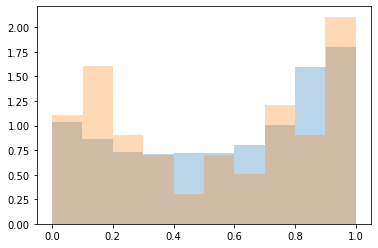

In [553]:
plt.hist(X,density=True,alpha=0.3)
plt.hist(np.random.choice(X.flatten(),100),density=True,alpha=0.3)

1.0729869411330215


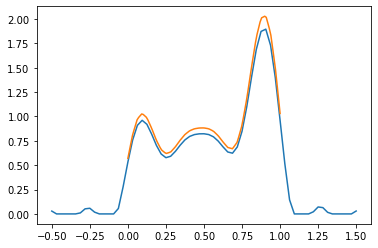

In [612]:
from fastkde import fastKDE

subset_X = np.random.choice(X.flatten(),1000)

cOfX,axis = fastKDE.pdf(subset_X);

plt.plot(axis,cOfX)

def transform_point(x):
    f_x = np.sum(axis<x)
    wx = np.abs((axis[f_x]-x)/(axis[f_x]-axis[f_x-1]))
    return (1-wx)*cOfX[f_x] + wx*cOfX[f_x-1]

x = np.linspace(0,1,100)
y = np.array([transform_point(i) for i in x])
k = len(x)/y.sum()
print(k)
y = y*k
plt.plot(x,y)

In [ ]:
subset_X = np.sort(subset_X)
model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
points = torch.linspace(0,1,len(subset_X)).float()
#pS = torch.ones(len(points))*1/(len(points))
pS = torch.tensor([transform_point(i) for i in subset_X]).float()
pS = pS/pS.sum()
%time (MI, dMI) = measure_MI(model, points, pS=pS, f_mc_size=20)
print(MI,dMI)
points = torch.tensor(subset_X).float()
%time (MI, dMI) = measure_MI(model, points, pS=None, f_mc_size=20)
print(MI,dMI)

['/home/nina/models/ST263_Day4/model_1-4.pth']
tensor(0.0002)
CPU times: user 4min 8s, sys: 2min 51s, total: 6min 59s
Wall time: 51.3 s
tensor(-0.1613) tensor(0.0052)


In [621]:
torch.allclose(pS.sum(),torch.ones(1))

True

In [8]:
def input_information(model, n: int, scale: float, samp_mc_size=100, device=torch.device('cpu')):
        ds = scale/n #scale determines units of ds
        
        points = torch.linspace(0,1,n+3)

        with torch.no_grad():
            fs = model(points).rsample(torch.Size([20])) #[samples_f, copulas, positions]
        fs = torch.einsum('ijk->jki', fs) #[copulas, positions, samples_f] 
        f = fs.reshape((fs.shape[0],-1)) #[copulas, (samples_f x positions)]
            
        copula = model.likelihood._get_copula(f, sample_size = torch.Size([samp_mc_size]))
        samples = copula.rsample()
        logprob = copula.log_prob(samples)
        
        logprob = logprob.reshape((*fs.shape[1:],-1)) #[positions, samples_f]

        #calculate FI
        FI = torch.zeros_like(logprob[...,0])
        for i in range(1,n):
            FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum(dim=-1)
            if (i>2) & (i<n-1):
                
#             #now calculate MI    
#             # P(r) = integral P(r|s) P(s) ds
#             Pr = torch.zeros(samples.shape[0]).cuda(device=get_cuda_device)
#             for i in range(n+1):
#                 Pr += logprob[i].exp().detach()*(1/(n+1))
#             MIs=0
#             for i in range(n+1):    
#                 MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log()) # sum p(r|s) * log p(r|s)/p(r)
#             MI = MIs.sum()     
        return (FI.mean(dim=-1),FI.std(dim=-1))

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (FI, dFI) = input_information(model, 160, 160, device=torch.device('cpu'))

IndentationError: expected an indented block (<ipython-input-8-1edd0510d82b>, line 32)

In [ ]:
plt.plot(np.linspace(0,160,len(FI)),FI)
plt.fill_between(np.linspace(0,160,len(FI)),FI-dFI,FI+dFI, alpha=0.3)